<a href="https://colab.research.google.com/github/FrancescoZanni/Temperature/blob/main/Temperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preliminary imports and setup

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install emcee

In [3]:
!pip install corner

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
import json
import os
from scipy.optimize import curve_fit
from matplotlib.pyplot import figure
import emcee
import corner
import random

In [5]:
ls

drive/  sample_data/


In [6]:
cd drive/MyDrive/KAGGLE

/content/drive/MyDrive/KAGGLE


In [7]:
mkdir -p temperature

In [8]:
cd temperature

/content/drive/MyDrive/KAGGLE/temperature


In [9]:
ls

city_temperature.csv


##Import of the dataset from my google drive

In [10]:
raw_data = pd.read_csv("city_temperature.csv")

<ipython-input-10-558755eb7cbb>:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv("city_temperature.csv")


Initial data exploration

In [11]:
raw_data.columns

Index(['Region', 'Country', 'State', 'City', 'Month', 'Day', 'Year',
       'AvgTemperature'],
      dtype='object')

In [12]:
raw_data.head()

,Region,Country,State,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,NaN,Algiers,1,1,1995,64.2
1,Africa,Algeria,NaN,Algiers,1,2,1995,49.4
2,Africa,Algeria,NaN,Algiers,1,3,1995,48.8
3,Africa,Algeria,NaN,Algiers,1,4,1995,46.4
4,Africa,Algeria,NaN,Algiers,1,5,1995,47.9


Checking for missing values


In [13]:
print(raw_data.isna().sum())

Region                  0
Country                 0
State             1450990
City                    0
Month                   0
Day                     0
Year                    0
AvgTemperature          0
dtype: int64


In [14]:
raw_data.State.unique()

array([nan, 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Maryland', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois',
       'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming', 'Additional Territories'],
      dtype=object)

In [15]:
raw_data.drop("State", axis = 1)

,Region,Country,City,Month,Day,Year,AvgTemperature
0,Africa,Algeria,Algiers,1,1,1995,64.2
1,Africa,Algeria,Algiers,1,2,1995,49.4
2,Africa,Algeria,Algiers,1,3,1995,48.8
3,Africa,Algeria,Algiers,1,4,1995,46.4
4,Africa,Algeria,Algiers,1,5,1995,47.9
...,...,...,...,...,...,...,...
2906322,North America,US,San Juan Puerto Rico,7,27,2013,82.4
2906323,North America,US,San Juan Puerto Rico,7,28,2013,81.6
2906324,North America,US,San Juan Puerto Rico,7,29,2013,84.2
2906325,North America,US,San Juan Puerto Rico,7,30,2013,83.8


State column is not useful so I delete it \\
Next I plot the data from the city of Barcelona to have a first look: there are missing values set to -99

In [16]:
print("Total number of cities: ", raw_data.City.unique().size)

Total number of cities:  321


Text(0.5, 1.0, 'Barcelona average temperatures')

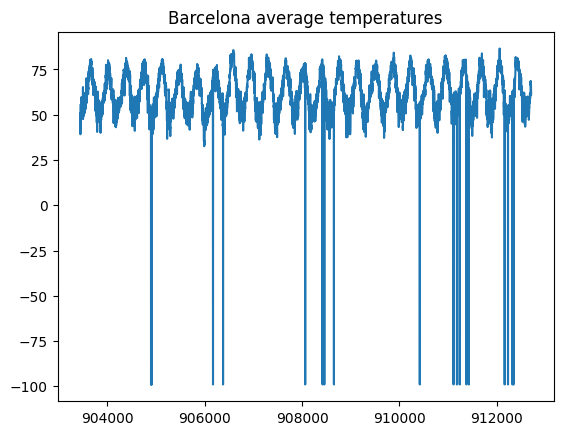

In [17]:
pl.plot(raw_data[raw_data.City == "Barcelona"].AvgTemperature)
pl.title("Barcelona average temperatures")


For a random subset of 20 cities the percentage of missing values over all values is shown


In [18]:
 for c in random.sample(sorted(raw_data.City.unique()),20):
   print( c + ": {0:1.4} %".format(raw_data[raw_data.City ==c][raw_data.AvgTemperature ==-99].AvgTemperature.count()/ raw_data[raw_data.City==c].AvgTemperature.sum()*100))

<ipython-input-18-86ad403d2f89>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print( c + ": {0:1.4} %".format(raw_data[raw_data.City ==c][raw_data.AvgTemperature ==-99].AvgTemperature.count()/ raw_data[raw_data.City==c].AvgTemperature.sum()*100))


Abu Dhabi: 0.004464 %
Yerevan: 0.02194 %
Moscow: 0.00798 %
Jakarta: 0.7219 %
Rockford: 0.009338 %
Tulsa: 0.003184 %
Bombay (Mumbai): 0.003971 %
Indianapolis: 0.003647 %
Buffalo: 0.003331 %
Memphis: 0.00257 %
Montvideo: 0.006549 %
Spokane: 0.003366 %
Billings: 0.009595 %
Fargo: 0.006377 %
Ottawa: 0.004487 %
Dhaka: 3.819 %
Flint: 0.003785 %
Macon: 0.002872 %
Barcelona: 0.005284 %
Harrisburg: 0.004854 %


Fill in the missing values by interpolating the previous and the next value \\
Convert from Farenheit to Cesius

In [19]:
# Fill the missing values by linear interpolation of previous and next value

raw_data['AvgTemperature'] = raw_data['AvgTemperature'].replace(-99, float('nan'))
raw_data['AvgTemperature'] = raw_data['AvgTemperature'].interpolate( "linear")

#conversion from Fareheit to Celsius
raw_data['AvgTemperature'] = (raw_data['AvgTemperature']-32)/1.8

Check that the missing values are correctly removed

Text(0.5, 0, 'Incremental date')

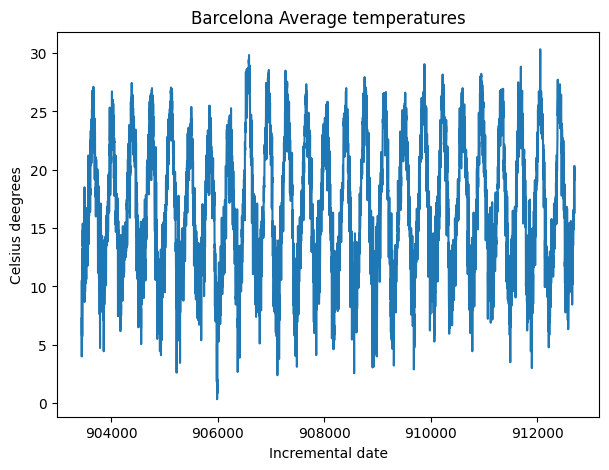

In [20]:

ax = pl.figure(figsize=(7,5)).add_subplot(111)
ax.plot(raw_data[raw_data.City == "Barcelona"].AvgTemperature)
ax.set_title("Barcelona Average temperatures")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")


##Histograms of the distibution of temperature for a random subset of 10 cities

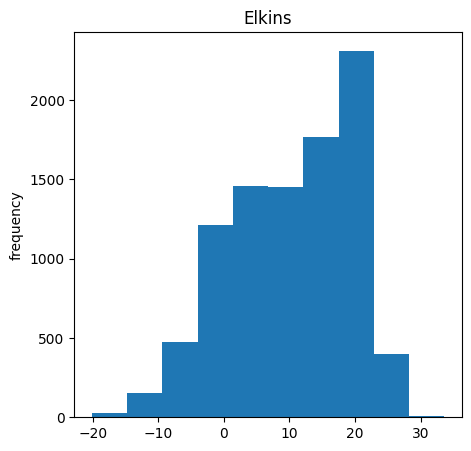

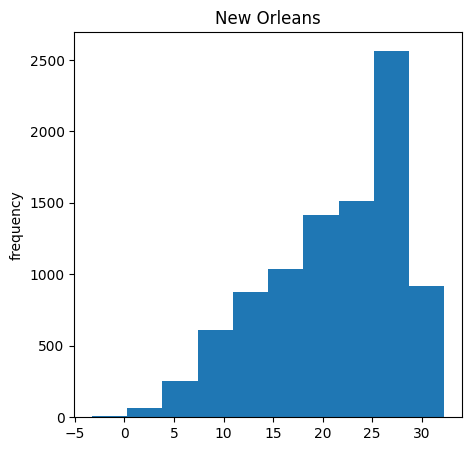

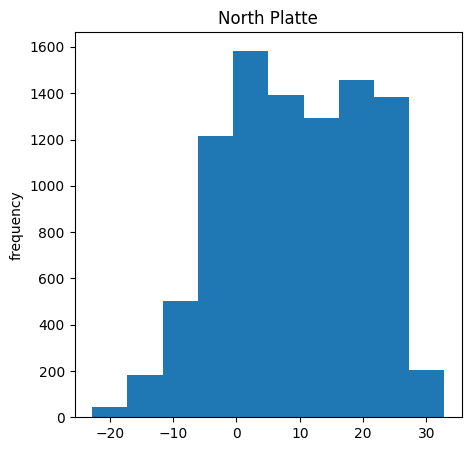

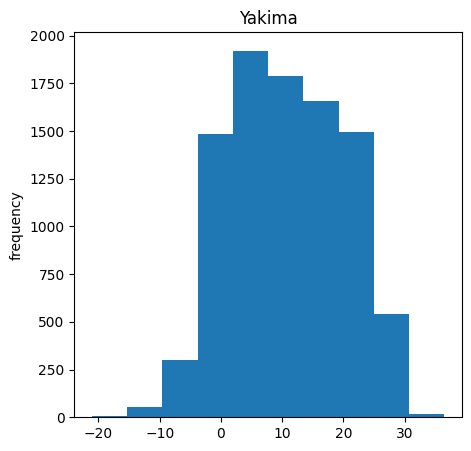

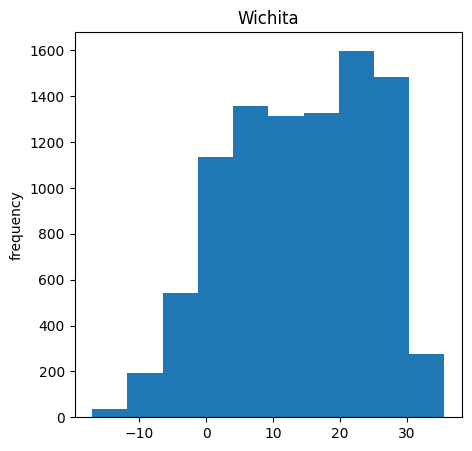

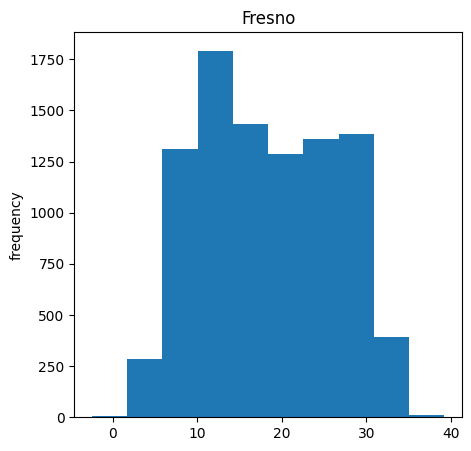

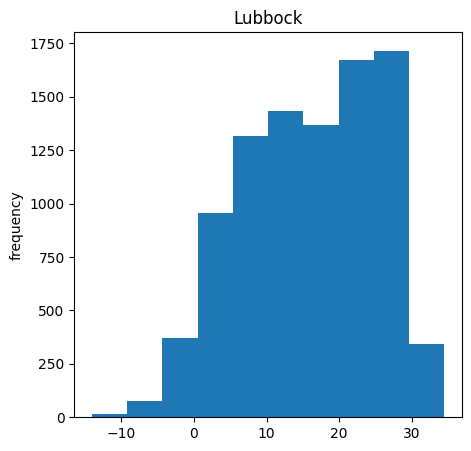

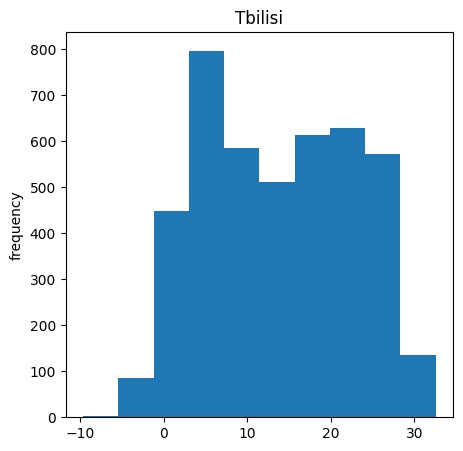

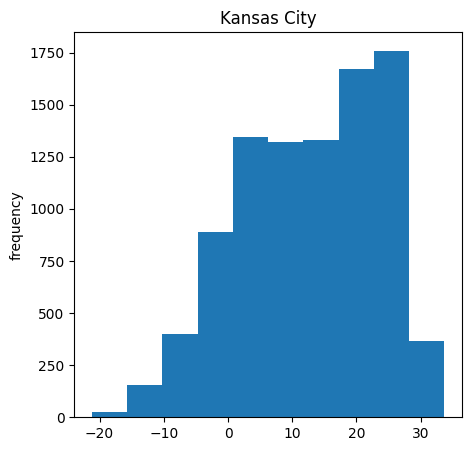

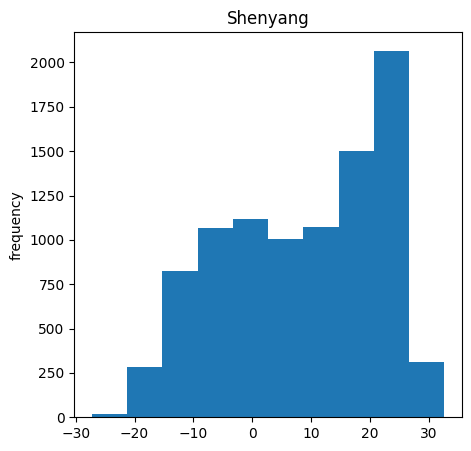

In [21]:
  for c in random.sample(sorted(raw_data.City.unique()),10):
    ax = pl.figure(figsize=(5,5)).add_subplot(111)
    ax.hist(raw_data[raw_data.City==c].AvgTemperature)
    ax.set_title(c)
    ax.set_ylabel("frequency")


##Todo: Check for Feb 29th and "march 0th" (leap years inconsistencies)
and convert from year-month-day to "julian date"

In [22]:
raw_data[raw_data.Month ==3][raw_data.Day==0]

<ipython-input-22-d8d55ef186e8>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  raw_data[raw_data.Month ==3][raw_data.Day==0]


,Region,Country,State,City,Month,Day,Year,AvgTemperature
82774,Africa,Guinea,NaN,Conakry,3,0,2008,28.625000
85697,Africa,Guinea,NaN,Conakry,3,0,2016,28.703704
92041,Africa,Guinea-Bissau,NaN,Bissau,3,0,2008,27.000000
146077,Africa,Malawi,NaN,Lilongwe,3,0,2012,22.638889
177862,Africa,Nigeria,NaN,Lagos,3,0,2008,27.110434
241159,Africa,Uganda,NaN,Kampala,3,0,2012,22.740741
1209901,North America,Mexico,NaN,Guadalajara,3,0,2012,20.444444
1333910,South/Central America & Carribean,Cuba,NaN,Havana,3,0,2008,23.638889


# Definition of the model and parameter fitting

Seasonality: $$s(t) = a_0 + bt + a1 \sin\Big(2\pi\frac{t+f}{365}\Big) +  b1 \cos\Big(2\pi\frac{t+g}{365}\Big)$$

In [23]:
#parameters
a0 = 1
b = 0.001
a1 = 1
b1 = 1
f = 0
g = 0



def s(t, a0, a1, b, b1, f, g):
    return a0 + b*t + a1 * np.sin(2*np.pi*(t+f)/365) + b1 * np.cos(2*np.pi*(t+g)/365)

Variance:
$$ \sigma^2 (t)=c+\sum_{i=1}^{4}c_i\sin\Big(\frac{2i\pi t}{365}\Big)+\sum_{j=1}^{4}d_j \cos\Big(\frac{2j\pi t}{365}\Big)$$

In [24]:
def sigma(t, c, c1,c2,c3,c4, d1,d2,d3,d4):
  return np.sqrt(c+ c1*np.sin((2*np.pi*t)/(365))+ c2*np.sin((4*np.pi*t)/(365))+ c3*np.sin((6*np.pi*t)/(365))+ c4*np.sin((8*np.pi*t)/(365))+\
  d1*np.cos((2*np.pi*t)/(365))+ d2*np.cos((4*np.pi*t)/(365))+ d3*np.cos((6*np.pi*t)/(365))+ d4*np.cos((8*np.pi*t)/(365)))

Definition of a trial set to explore the methodology \\
I take the temperature data from the city of Barcelona


In [25]:

#y is the vector with the average temperature of Barcelona
y = raw_data[raw_data.City == "Barcelona"].AvgTemperature
#x is a vector of values from 1 to len(y) with integer steps
x = np.arange(1, len(y)+1)


Text(0.5, 0, 'Incremental date')

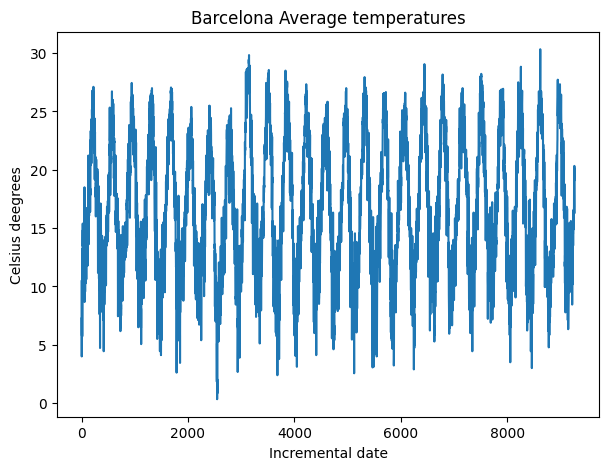

In [26]:
ax = pl.figure(figsize=(7,5)).add_subplot(111)
ax.plot(x,y)
ax.set_title("Barcelona Average temperatures")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")


##Linear regression to find out the temperature growth trend#
Proceeding as in https://www.duo.uio.no/bitstream/handle/10852/10566/pm12-05.pdf?sequence=1  \\
First with a linear fit to compute the upward linear trend in the s(t)

In [27]:

def moving_average(arr, window_size):
    if window_size <= 0 or window_size > len(arr):
        raise ValueError("Invalid window size")

    moving_averages = []
    for i in range(len(arr)):
        start = max(0, i - window_size + 1)
        end = i + 1
        window = arr[start:end]
        avg = sum(window) / len(window)
        moving_averages.append(avg)

    return moving_averages

# Example usage:

window_size = 365
averages = moving_average(y, window_size)

Fitted parameters: a0 = 7.524623260624086e-05, b = 16.195576371865066


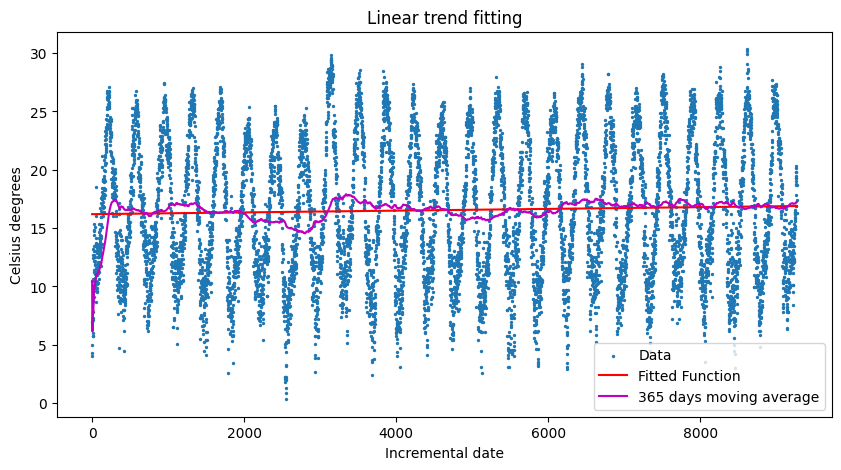

In [28]:

def line(x, a, b):
    return a * x + b


params_line, covariance = curve_fit(line, x, y)

# Extract the optimized parameters
a, b = params_line

# Generate fitted data using the optimized parameters
y_linearfit = line(x, a, b)

# Plot the original data and the fitted function


ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.scatter(x,y, label = "Data", s=2)
ax.plot(x,y_linearfit, 'r-', label='Fitted Function')
ax.plot(x,averages, 'm-', label="365 days moving average")
ax.set_title("Linear trend fitting")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()





print(f"Fitted parameters: a0 = {a}, b = {b}")

In [29]:
print("The trend sees the temperature growing of 1C every {0:2.2f} years".format(1/(a*365)))
#Subtract the upward trend to isolate the seasonality
y_detrended = y-line(x,a,b)

The trend sees the temperature growing of 1C every 36.41 years


##Regression to find out the seasonality parameters
After subtracting the linear trend the periodic part of the seasonality is computed

In [30]:
#definition of the s(t) function without the linear trend
def s_detrended(t, a1, b1, f, g):
    return a1 * np.sin(2*np.pi*(t+f)/365) + b1 * np.cos(2*np.pi*(t+g)/365)

In [31]:
#Fitting
params_detrended, covariance = curve_fit(s_detrended, x, y_detrended)

In [32]:
print("Parameters found are: ")
print("a1: {0:2.4f}".format(params_detrended[0]))
print("b1: {0:2.2f}".format(params_detrended[1]))
print("f: ", params_detrended[2])
print("g: {0:2.2f}".format(params_detrended[3]))


Parameters found are: 
a1: -6.7258
b1: 7.73
f:  -734.7067577329427
g: -161.20


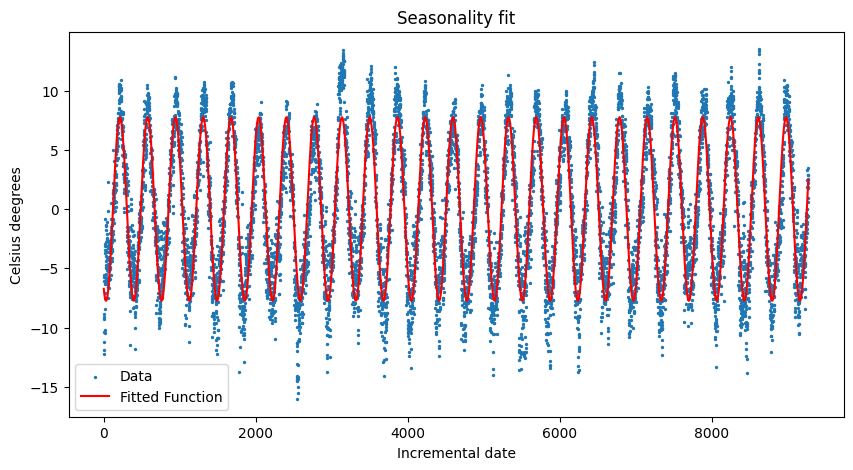

In [33]:


ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.scatter(x,y_detrended, label = "Data", s=2)
ax.plot(x,s_detrended(x,*params_detrended), 'r-', label='Fitted Function')
ax.set_title("Seasonality fit")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()

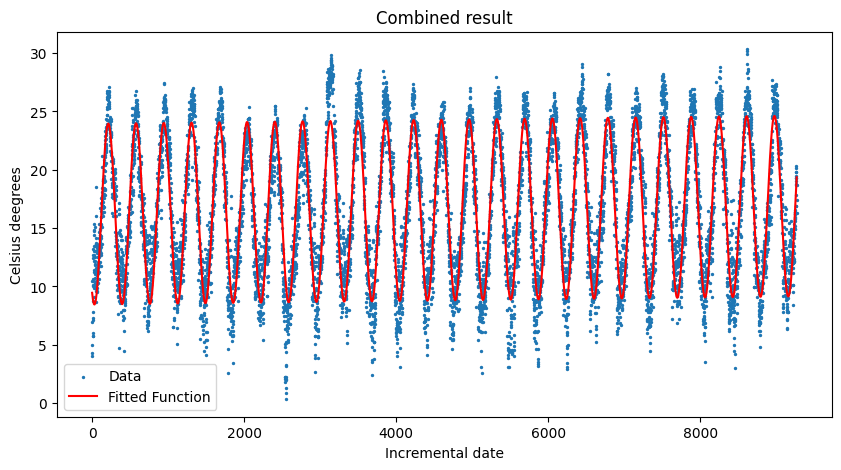

In [34]:
#complete set of parameters
params_complete = [a,b,*params_detrended]
# Generate fitted data using the optimized parameters
y_fit = line(x,a,b)+s_detrended(x, *params_detrended)

# Plot the original data and the fitted function


ax = pl.figure(figsize=(10,5)).add_subplot(111)
ax.scatter(x,y, label = "Data", s=2)
ax.plot(x,y_fit, 'r-', label='Fitted Function')
ax.set_title("Combined result")
ax.set_ylabel("Celsius deegrees")
ax.set_xlabel("Incremental date")
ax.legend()


##Fitting of the volatility



In [35]:
#substract the seasonality to isolate the volatility
y_deseason = y- y_fit

Text(0.5, 1.0, 'De-trended and de-seasonalized temperature')

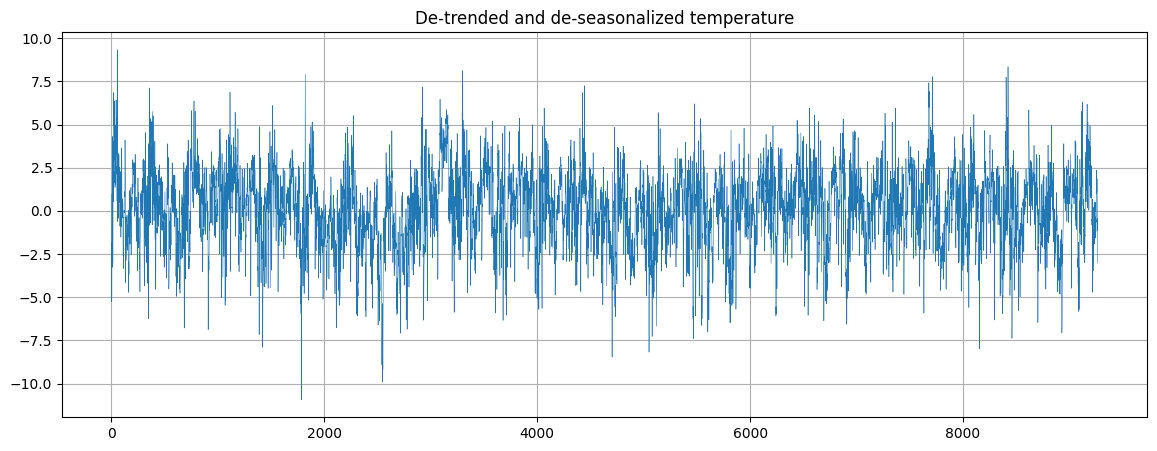

In [36]:
from pandas.core.reshape.api import wide_to_long
fig, ax = pl.subplots(figsize = (14,5))

ax.plot(x,y_deseason, linewidth = .4)
ax.grid(True)
ax.set_title("De-trended and de-seasonalized temperature")

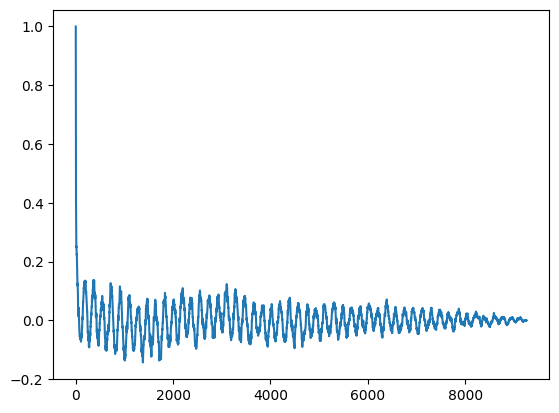

In [37]:
#Autocorrelation function

def autocorrelation(vector, max_distance):

    autocorr = np.correlate(vector, vector, mode='full')
    autocorr = autocorr / np.max(autocorr)  # Normalizza i valori tra -1 e 1
    return autocorr[len(autocorr) // 2:len(autocorr) // 2 + max_distance + 1]

autocorr = autocorrelation(y_deseason, len(y_deseason))

pl.plot(autocorr)

##Fitting the whole s(t) all at once

This consists in fitting the entire s(t) in one time instead of isolating the linear trend first, so it differs from the cited paper.


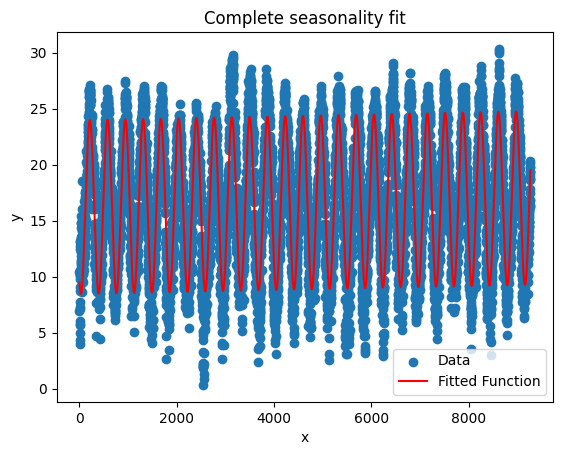

In [38]:
params, covariance = curve_fit(s, x, y)


y_fitcomplete = s(x, *params)

# Plot the original data and the fitted function
pl.scatter(x, y, label='Data')
pl.plot(x, y_fitcomplete, 'r-', label='Fitted Function')
pl.legend()
pl.xlabel('x')
pl.ylabel('y')
pl.title("Complete seasonality fit")
pl.show()


Comparison of the two methods: 
First:  [7.524623260624086e-05, 16.195576371865066, -6.725834140628428, 7.731234703666865, -734.7067577329427, -161.1999413437703]
Second:  [ 1.62031265e+01 -4.61558858e+01  8.87691069e-05  3.86062722e+01
  7.78313694e+02 -7.75327660e+02]


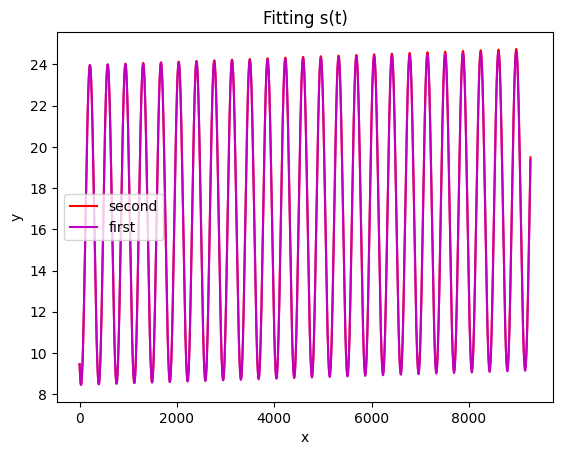

In [39]:
print("Comparison of the two methods: ")
print(f"First: ", params_complete)
print(f"Second: ", params)

#pl.scatter(x, y, label='Data')
pl.plot(x, y_fitcomplete, 'r-', label='second')
pl.plot(x, y_fit, 'm-', label = "first")
pl.legend()
pl.xlabel('x')
pl.ylabel('y')
pl.title('Fitting s(t)')
pl.show()

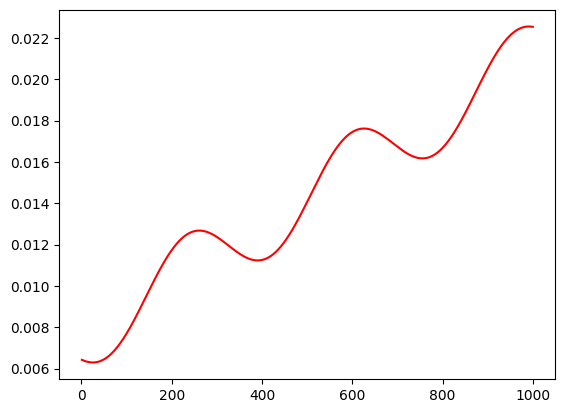

In [40]:
pl.plot(x[0:1000], y_fitcomplete[0:1000]-y_fit[0:1000], 'r-', label='second')

Very different parameters but same result (?)

#Maximum likelihood whith Monte Carlo



In [41]:
#theta is the parameters array
#theta = [a0,a1,b,b1,f,g]

In [42]:
def log_prior(theta):
  #no prior constraints on the parameters
  return 0

In [43]:
def log_likelihood(theta, x, y):
  a0,a1,b,b1,f,g = theta
  #set the likelihood as the sum of the squared residuals
  return -np.sum((y-s(x, *theta))**2)

In [44]:
def log_probability(theta, x, y):
  #since there is no prior the probability is the likelihood
  return log_likelihood(theta,x,y)

##MCMC to explore the parameter space

In [45]:
ig = params_complete  #initial guess set to the parameters found by the previous fitting (the idea is to have less burn-in)
#ig = [1,1,1,1,1,1] #uninformed initial guess
ndim = len(ig)
nwalkers = 16
pos = np.array(ig)+ 1e-4 * np.random.randn(nwalkers,ndim) #starting positions randomized around the initial guess

pos.shape

(16, 6)

Slow computation!

In [52]:
# #Using emcee to explore the parameter space
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y))
sampler.run_mcmc(pos, 20000, progress=True); #run the emcee for 20000 steps
samples = sampler.get_chain() #get the path of each walker

flat_samples = sampler.get_chain(discard=200, thin=15, flat=True) #throw away burn in phase


100%|██████████| 20000/20000 [05:45<00:00, 57.85it/s]


In [54]:

results = np.zeros((ndim,1))
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])   #extract the interquartile range and median solution for each parameter
  results[i] = np.mean(flat_samples[:,i])   #extract the mean points
print(results)
print(np.size(results))
print(np.size(mcmc[:,1]))


[[ 1.62782287e+01]
 [-5.41432173e+00]
 [ 7.57177516e-05]
 [ 4.63424932e+00]
 [-7.06183882e+02]
 [-1.68391746e+02]]
6
6


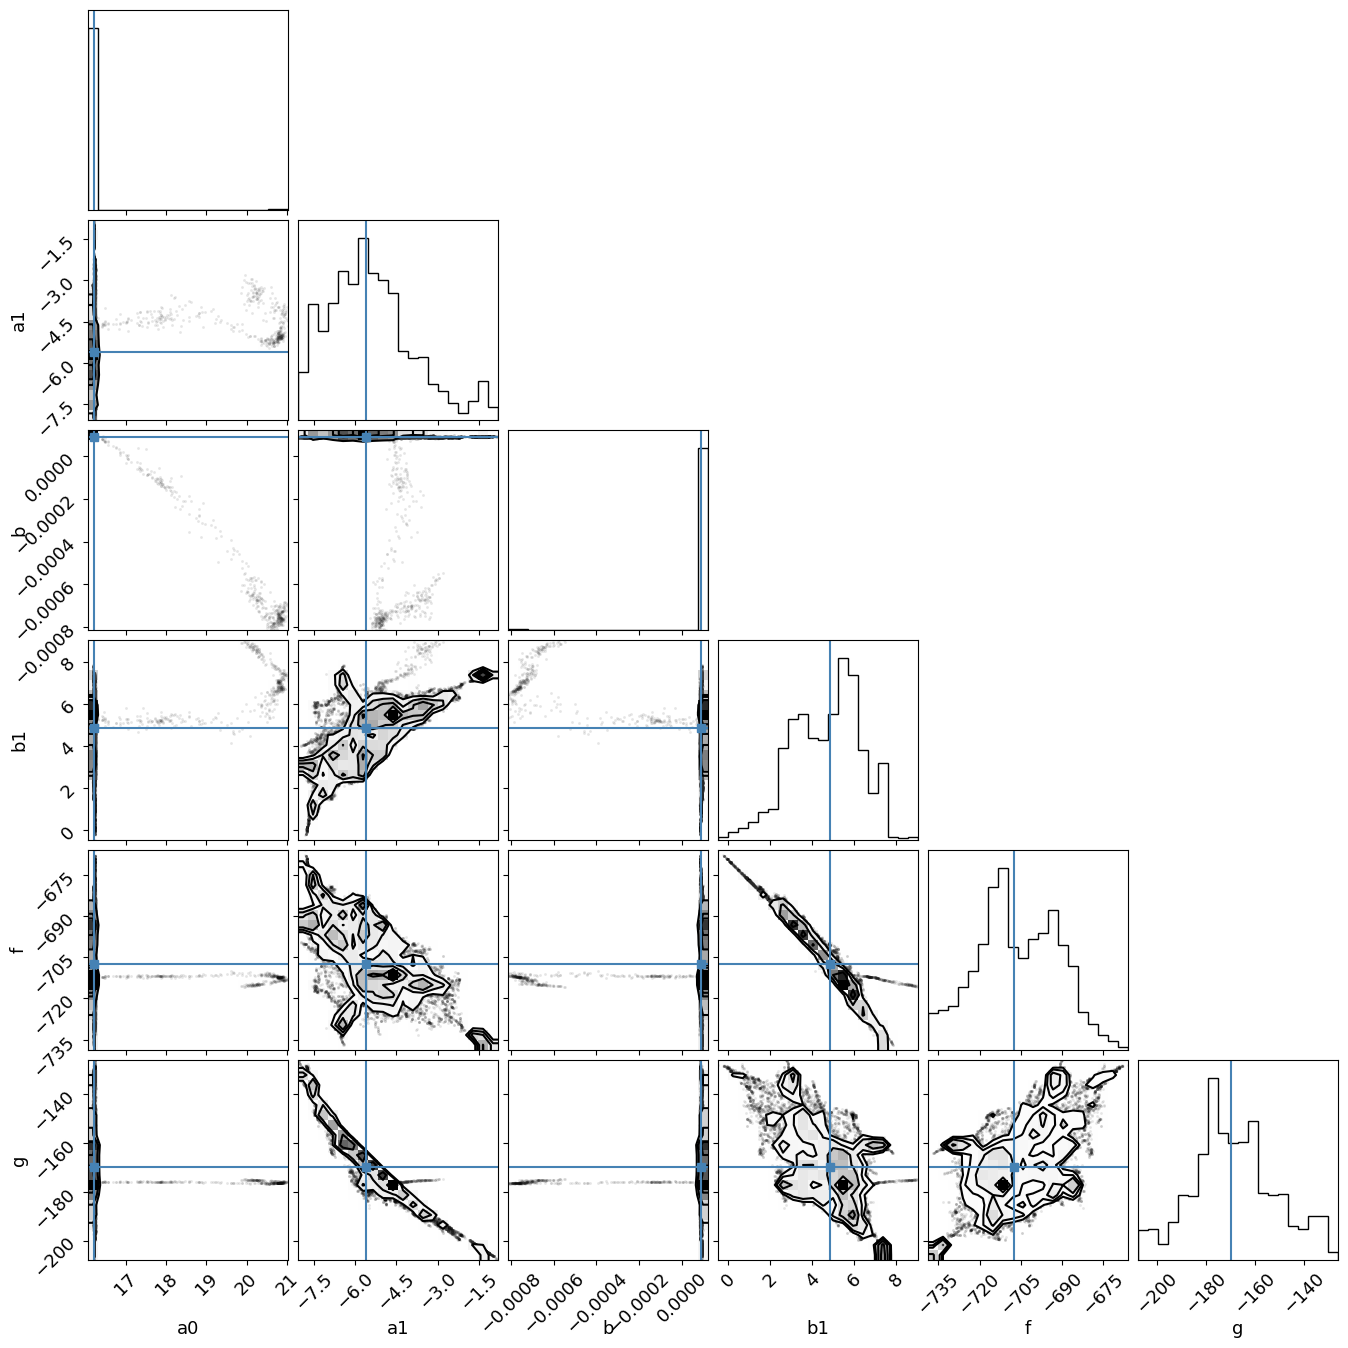

In [57]:
#triangle plot to visualize the parameter distributions (something broken?)
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["a0","a1","b","b1","f","g"], truths=mcmc[:,1]);

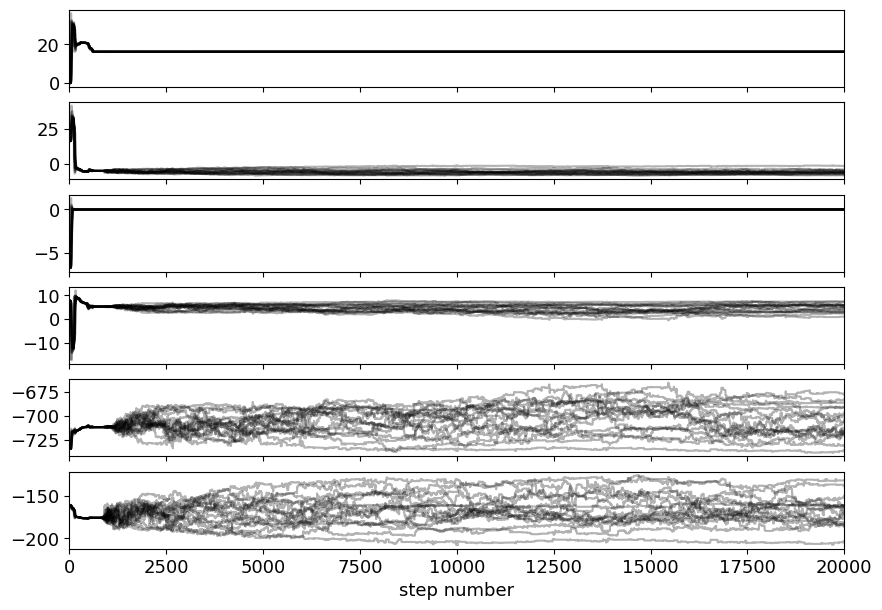

In [58]:
#Visualise the Markov chains (not ideal)
fig, axes = pl.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

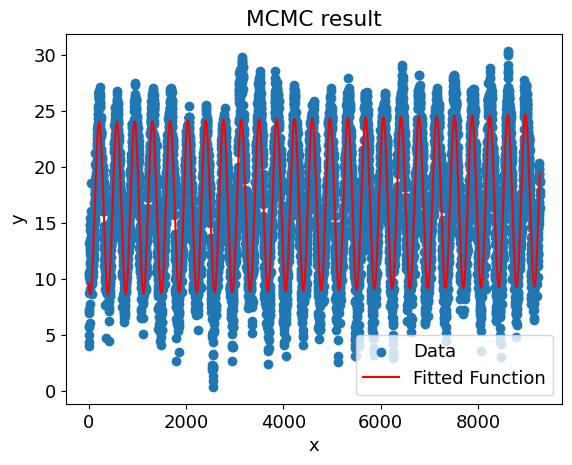

In [59]:
#Repeat the plot with the new parameters obtained

y_MCMC = s(x, *results)

# Plot the original data and the fitted function
pl.scatter(x, y, label='Data')
pl.plot(x, y_MCMC, 'r-', label='Fitted Function')
pl.legend()
pl.xlabel('x')
pl.ylabel('y')
pl.title('MCMC result')
pl.show()



In [60]:
print("Curve fit parameters: ", params_complete)
print("Monte Carlo parameters", results)

Curve fit parameters:  [7.524623260624086e-05, 16.195576371865066, -6.725834140628428, 7.731234703666865, -734.7067577329427, -161.1999413437703]
Monte Carlo parameters [[ 1.62782287e+01]
 [-5.41432173e+00]
 [ 7.57177516e-05]
 [ 4.63424932e+00]
 [-7.06183882e+02]
 [-1.68391746e+02]]


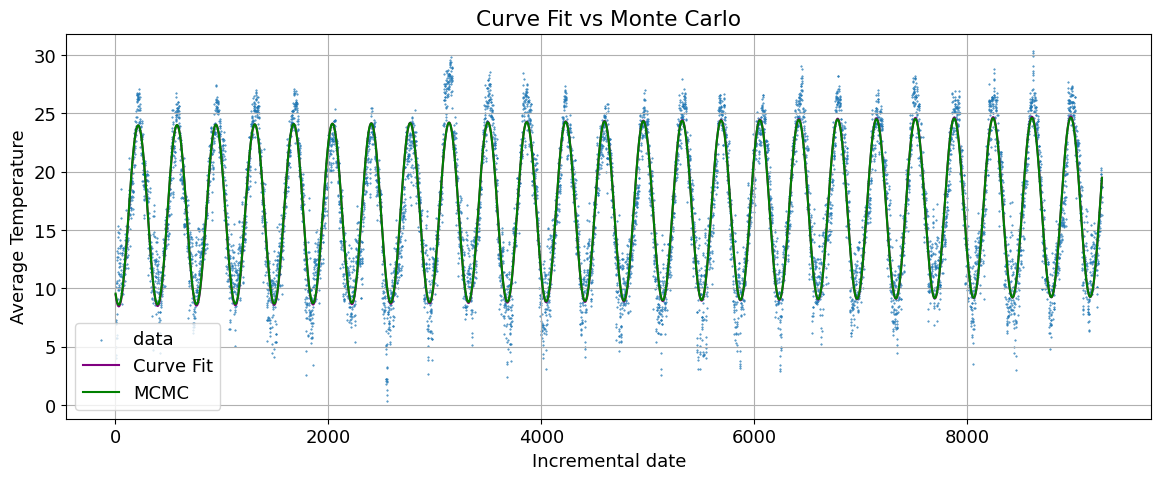

In [61]:


fig, ax = pl.subplots(figsize = (14,5))

ax.scatter(x,y, label ="data", s=.2)
ax.plot(x,y_fitcomplete,  label = "Curve Fit", linewidth = 1.5, color = "purple")
ax.plot(x,y_MCMC, label="MCMC", linewidth = 1.5, color = "green")
ax.legend()
ax.set_xlabel("Incremental date")
ax.set_ylabel("Average Temperature")
ax.set_title("Curve Fit vs Monte Carlo")
ax.grid(True)
